# Data-Minding Group Progress Report

## Project Introduction
This project analyzes U.S. air pollution trends in urban vs. rural areas using 2023–2024 data. While urban pollution stems from traffic and industry, rural regions face challenges from agriculture and natural sources. We examine pollutants (CO, NO₂, SO₂, O₃) and weather data to understand what drives regional AQI patterns.
## Scope Changes
**What Stayed the Same:**
- Focus on urban vs. rural AQI comparisons using 2023–2024 pollutant and weather data.

**What Changed:**
- Expanded analysis to all 50 states.
- Plan to incorporate traffic and industrial activity data.
- Will use Census/USDA data to define rural vs. urban.

**Removed:**
- PM2.5 analysis (due to missing data).
- County-level modeling delayed in favor of state-level clarity.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import math
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Data Cleaning

Data Overview
Structure: Tabular CSVs with daily pollutant and weather measurements per county.

Granularity: Daily, county-level; also aggregated to state-level for modeling.

Scope: 24 U.S. states, covering CO, NO₂, SO₂, O₃, and weather data (2023–2024).

Temporality: Daily data from Jan 2023 to Dec 2024, capturing seasonal trends.

Faithfulness: Reliable EPA data; high quality but some gaps (e.g., PM2.5); rural/urban tagging to be added.

In [73]:
def clean_pollutant_dataset(df, pollutant_standard=None):
    # Optional filter for pollutant standard (e.g., CO 8-hour 1971)
    if pollutant_standard and 'Pollutant Standard' in df.columns:
        df = df[df['Pollutant Standard'] == pollutant_standard]

    # Convert 'Date Local' to datetime and drop rows with invalid dates
    if 'Date Local' in df.columns:
        df['Date Local'] = pd.to_datetime(df['Date Local'], errors='coerce')
        df = df.dropna(subset=['Date Local'])

    # Drop duplicate rows
    df = df.drop_duplicates()

    return df

def combine_datasets_POLLUTANTS(file1, file2, file3, file4, output_file):
    # Load and clean each dataset
    df1 = clean_pollutant_dataset(pd.read_csv(file1))  # Ozone
    df2 = clean_pollutant_dataset(pd.read_csv(file2), pollutant_standard='SO2 1-hour 2010')
    df3 = clean_pollutant_dataset(pd.read_csv(file3), pollutant_standard='CO 8-hour 1971')
    df4 = clean_pollutant_dataset(pd.read_csv(file4))  # NO2

    # Select relevant columns and rename for clarity
    df1 = df1[['State Name', 'County Name', 'Date Local', 'Local Site Name',
               'Arithmetic Mean', '1st Max Value', '1st Max Hour']].rename(
        columns={
            'Arithmetic Mean': 'Arithmetic Mean_ozone',
            '1st Max Value': '1st Max Value_ozone',
            '1st Max Hour': '1st Max Hour_ozone'
        })

    df2 = df2[['State Name', 'County Name', 'Date Local', 'Local Site Name',
               'Arithmetic Mean', '1st Max Value', '1st Max Hour']].rename(
        columns={
            'Arithmetic Mean': 'Arithmetic Mean_so2',
            '1st Max Value': '1st Max Value_so2',
            '1st Max Hour': '1st Max Hour_so2'
        })

    df3 = df3[['State Name', 'County Name', 'Date Local', 'Local Site Name',
               'Arithmetic Mean', '1st Max Value', '1st Max Hour']].rename(
        columns={
            'Arithmetic Mean': 'Arithmetic Mean_co',
            '1st Max Value': '1st Max Value_co',
            '1st Max Hour': '1st Max Hour_co'
        })

    df4 = df4[['State Name', 'County Name', 'Date Local', 'Local Site Name',
               'Arithmetic Mean', '1st Max Value', '1st Max Hour']].rename(
        columns={
            'Arithmetic Mean': 'Arithmetic Mean_no2',
            '1st Max Value': '1st Max Value_no2',
            '1st Max Hour': '1st Max Hour_no2'
        })

    # Merge datasets on common keys
    merged_df = pd.merge(df1, df2, on=['State Name', 'County Name', 'Date Local', 'Local Site Name'], how='inner')
    merged_df = pd.merge(merged_df, df3, on=['State Name', 'County Name', 'Date Local', 'Local Site Name'], how='inner')
    merged_df = pd.merge(merged_df, df4, on=['State Name', 'County Name', 'Date Local', 'Local Site Name'], how='inner')

    # Sort by location and date
    merged_df = merged_df.sort_values(by=['State Name', 'County Name', 'Date Local'])

    # Save to CSV
    merged_df.to_csv(output_file, index=False)
    print(f"Merged pollutant dataset saved to: {output_file}")

In [ ]:
combine_datasets_POLLUTANTS(
    "daily_44201_2023.csv",  "daily_42401_2023.csv", "daily_42101_2023.csv", "daily_42602_2023.csv", "merged_ALL_POLLUTANTS_2023.csv"
)

In [ ]:
combine_datasets_POLLUTANTS(
    "daily_44201_2024.csv", "daily_42401_2024.csv", "daily_42101_2024.csv", "daily_42602_2024.csv", "merged_ALL_POLLUTANTS_2024.csv"
)

In [ ]:
def combine_datasets_METEO(file1, file2, file3, file4, output_file):
    # Read all four datasets
    df1 = pd.read_csv(file1)  #
    df2 = pd.read_csv(file2)  # SO2
    df3 = pd.read_csv(file3)  # CO
    df4 = pd.read_csv(file4)  # NO2
    df5 = df4.copy()

    # filtered_df = df[df['Ozone'] > 0.03]
    df4 = df4[df4['Parameter Name'] == 'Wind Speed - Resultant']
    df5 = df5[df5['Parameter Name'] == 'Wind Direction - Resultant']

    # Select the relevant columns and rename them for each dataset
    df1 = df1[['State Name', 'County Name', 'Date Local', 'Local Site Name', 'Arithmetic Mean', '1st Max Value', '1st Max Hour']].rename(
        columns={'Arithmetic Mean': 'Arithmetic Mean_PRESS', '1st Max Value': '1st Max Value_PRESS', '1st Max Hour': '1st Max Hour_PRESS'})
    df2 = df2[['State Name', 'County Name', 'Date Local', 'Local Site Name', 'Arithmetic Mean', '1st Max Value', '1st Max Hour']].rename(
        columns={'Arithmetic Mean': 'Arithmetic Mean_RH_DP', '1st Max Value': '1st Max Value_RH_DP', '1st Max Hour': '1st Max Hour_RH_DP'})
    df3 = df3[['State Name', 'County Name', 'Date Local', 'Local Site Name', 'Arithmetic Mean', '1st Max Value', '1st Max Hour']].rename(
        columns={'Arithmetic Mean': 'Arithmetic Mean_TEMP', '1st Max Value': '1st Max Value_TEMP', '1st Max Hour': '1st Max Hour_TEMP'})
    df4 = df4[['State Name', 'County Name', 'Date Local', 'Local Site Name', 'Arithmetic Mean', '1st Max Value', '1st Max Hour']].rename(
        columns={'Arithmetic Mean': 'Arithmetic Mean_WIND_SPEED', '1st Max Value': '1st Max Value_WIND_SPEED', '1st Max Hour': '1st Max Hour_WIND_SPEED'})
    df5 = df5[['State Name', 'County Name', 'Date Local', 'Local Site Name', 'Arithmetic Mean', '1st Max Value', '1st Max Hour']].rename(
        columns={'Arithmetic Mean': 'Arithmetic Mean_WIND_DIRECTION', '1st Max Value': '1st Max Value_WIND_DIRECTION', '1st Max Hour': '1st Max Hour_WIND_DIRECTION'})

    # Merge the datasets on common columns ('State Code', 'County Code', 'Date Local', 'Local Site Name')
    merged_df = pd.merge(df1, df2, on=['State Name', 'County Name', 'Date Local', 'Local Site Name'], how='inner')
    merged_df = pd.merge(merged_df, df3, on=['State Name', 'County Name', 'Date Local', 'Local Site Name'], how='inner')
    merged_df = pd.merge(merged_df, df4, on=['State Name', 'County Name', 'Date Local', 'Local Site Name'], how='inner')
    merged_df = pd.merge(merged_df, df5, on=['State Name', 'County Name', 'Date Local', 'Local Site Name'], how='inner')

    merged_df = merged_df.sort_values(by=['State Name', 'County Name', 'Date Local'], ascending=[True, True, True])

    # Save the combined dataset to a CSV file
    merged_df.to_csv(output_file, index=False)
    print(f"Merged dataset saved to {output_file}")


combine_datasets_METEO("daily_PRESS_2023.csv", "daily_RH_DP_2023.csv", "daily_TEMP_2023.csv", "daily_WIND_2023.csv", "merged_ALL_METEO_2023.csv")
combine_datasets_METEO("daily_PRESS_2024.csv", "daily_RH_DP_2024.csv", "daily_TEMP_2024.csv", "daily_WIND_2024.csv", "merged_ALL_METEO_2024.csv")

## Data Cleaning Steps

- Filtered pollutant standards (e.g., **CO 8-hour 1971**, **SO2 1-hour 2010**) and wind parameters (**Wind Speed - Resultant**, **Wind Direction - Resultant**) for consistency.  
- Selected key features: **Arithmetic Mean**, **Max Value**, and **Max Hour** across all datasets.  
- Renamed columns to reflect their source and ensure uniqueness after merging.  
- Dropped unnecessary columns like **Local Site Name** in final merges.  
- Handled missing values implicitly by performing **inner joins**—retaining only rows with complete data across all selected variables.


In [77]:
def combine_datasets(file1, file2, file3, output_file):
    # Read all three datasets: pollutants, meteorology, aqi_by_county
    df1 = pd.read_csv(file1)  # pollutants
    df2 = pd.read_csv(file2)  # meteorology
    df3 = pd.read_csv(file3)  # aqi

    df1 = df1.drop('Local Site Name', axis=1)
    df2 = df2.drop('Local Site Name', axis=1)
    df3 = df3[['State Name', 'county Name', 'Date', 'AQI', 'Category']].rename(columns={'county Name': 'County Name'})

    # Merge the datasets on common columns ('State Code', 'County Code', 'Date Local', 'Local Site Name')
    merged_df = pd.merge(df1, df2, on=['State Name', 'County Name', 'Date Local'], how='inner')
    merged_df = merged_df.rename(columns={'Date Local': 'Date'})
    merged_df = pd.merge(merged_df, df3, on=['State Name', 'County Name', 'Date'], how='inner')
    # merged_df = pd.merge(merged_df, df4, on=['State Name', 'County Name', 'Date Local', 'Local Site Name'], how='inner')

    merged_df = merged_df.sort_values(by=['State Name', 'County Name', 'Date'], ascending=[True, True, True])

    # Save the combined dataset to a CSV file
    merged_df.to_csv(output_file, index=False)
    print(f"Merged dataset saved to {output_file}")

In [ ]:
combine_datasets("merged_ALL_METEO_2023.csv", "merged_ALL_POLLUTANTS_2023.csv", "daily_aqi_by_county_2023.csv", "all_attributes_2023.csv")

In [ ]:
combine_datasets("merged_ALL_METEO_2024.csv", "merged_ALL_POLLUTANTS_2024.csv", "daily_aqi_by_county_2024.csv", "all_attributes_2024.csv")

In [80]:
df = pd.read_csv('all_attributes_2023.csv')

unique_states = df['State Name'].unique()

df1 = pd.read_csv('all_attributes_2024.csv')

unique_states1 = df1['State Name'].unique()

# print(f"Number of unique states: {unique_states}")

# print(f"Number of unique states: {unique_states1}")

count = 0
commonState = []
for item in unique_states1:
    for i in unique_states:
        if (item == i):
            count += 1
            commonState.append(item)
            break

# print(count)
# print(len(commonState))
# print(commonState)

In [81]:
def filterRows(filename):
    commonState = ['Arizona', 'California', 'Connecticut', 'Georgia', 'Idaho', 'Illinois', 'Indiana', 'Louisiana', 'Maryland', 'Massachusetts', 'Michigan', 'Missouri', 'Nevada', 'New Hampshire', 'New Mexico', 'North Carolina', 'North Dakota', 'Ohio', 'Pennsylvania', 'Rhode Island', 'Texas', 'Virginia', 'Washington', 'Wyoming']

    match = re.search(r'_(\d{4})', filename)
    year = match.group(1)

    df = pd.read_csv(filename)

    # Filter rows where 'State Name' is in the commonState list
    filtered_df = df[df['State Name'].isin(commonState)]

    # Optional: Save to a new CSV file
    output_filename = f'24StateAQI_{year}.csv'
    filtered_df.to_csv(output_filename, index=False)

    # # Display the first few rows to verify
    # print(filtered_df.head())

In [82]:
filterRows("all_attributes_2023.csv")
filterRows("all_attributes_2024.csv")

# Exploratory data analysis

In [56]:
df = pd.read_csv('24StateAQI_2023.csv')
key_columns = ['AQI', 'Arithmetic Mean_TEMP', 'Arithmetic Mean_RH_DP']
df_key = df[key_columns]

# summary stats
mean = df_key.mean().round(2)
median = df_key.median().round(2)
mode = df[['AQI', 'Category', 'County Name', 'State Name']].mode().iloc[0]

print("Analysis of 2023 dataset")
print("Mean:")
for col in key_columns:
    print(f"{col.split('_')[-1]}: {mean[col]}")

print("Median:")
for col in key_columns:
    print(f"{col.split('_')[-1]}: {median[col]}")

print("Mode:")
print(f"AQI: {mode['AQI']} | Category: {mode['Category']} | County: {mode['County Name']} | State: {mode['State Name']}")

Analysis of 2023 dataset
Mean:
AQI: 69.77
TEMP: 63.4
DP: 60.25
Median:
AQI: 59.0
TEMP: 63.62
DP: 63.33
Mode:
AQI: 52 | Category: Moderate | County: Los Angeles | State: California


Findings: AQI mean 69.77 (Moderate condition), median 59 and mode 52, shows the occasional pollutions, where temperature and pollutants show moderate variation. Overall, the data is reliable for further analysis.

Hypothesis: Places that are hot and dry have higher risks of being polluted due to higher AQI.

Visulization description: The heatmap shows AQI is positively correlated with temperature (r = 0.41) and negatively correlated with humidity (r = -0.14), confirming that hot, dry conditions worsen air quality.

EDA: Loaded clean data, summarized key stats, analyzed correlations and outliers, explored temporal trends, and identified high-risk hot, dry regions. This is one factor that we can consider for our hypothesis, where it could be the case of counties that are hot and dry is higher risk of being polluted.

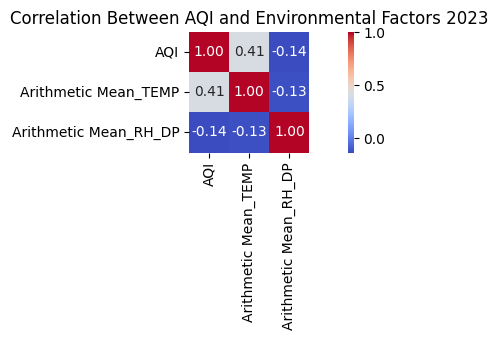

In [57]:
df = pd.read_csv('24StateAQI_2023.csv')
df['Date'] = pd.to_datetime(df['Date'])

corr_columns = [
    'AQI',
    'Arithmetic Mean_TEMP',
    'Arithmetic Mean_RH_DP',
]
corr_data = df[corr_columns].dropna()
corr_matrix = corr_data.corr()

plt.figure(figsize=(8,3.5))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Between AQI and Environmental Factors 2023')
plt.tight_layout()
plt.show()

Higher temperatures and lower humidity levels are strongly associated with increased AQI. This could be an interesting aspect to consider along with the hypothesis because this shows that places that are hot and dry have higher risks of being polluted.

# ML Analysis
Here we are using a multi-feature linear regression model to predict 2024 AQI using the 2023 figures. To evaluate performance, we will run a baseline where our 2023 AQI is our 2024 AQI. The analysis will be done by state.
- The below part for ML analysis is from ml.ipynb and random_forest_analysis.py

In [45]:
df_2023 = pd.read_csv("/content/24StateAQI_2023.csv")
df_2024 = pd.read_csv("/content/24StateAQI_2024.csv")

In [23]:
df_2023_bystate = df_2023.groupby("State Name", as_index=False)["AQI"].mean().rename(columns={"AQI": "AQI_2023"})
df_2024_bystate = df_2024.groupby("State Name", as_index=False)["AQI"].mean().rename(columns={"AQI": "AQI_2024"})
# aggregate by state name, get average aqi per state, we also rename some columns to avoid duplicate column names.

In [48]:
df = pd.merge(df_2023_bystate, df_2024_bystate, on="State Name")

X = df[['AQI_2023']].values
y = df['AQI_2024'].values

In [49]:
y_baseline = df['AQI_2023'].values
baseline_mse = mean_squared_error(y, y_baseline)
baseline_r2 = r2_score(y, y_baseline)
print("Baseline:")
print("Mean Squared Error:", baseline_mse)
print("R2 Score:", baseline_r2)
print(f"RMSE: {math.sqrt(baseline_mse)} AQI units")

Baseline:
Mean Squared Error: 66.29198501264854
R2 Score: 0.18764956246245157
RMSE: 8.141989008384163 AQI units


In [50]:
model = LinearRegression()
model.fit(X,y)
pred = model.predict(X)
#simple linear regression

In [51]:
lr_mse = mean_squared_error(y, pred)
lr_r2 = r2_score(y, pred)

print("Linear Regression Model:")
print("Mean Squared Error:", lr_mse)
print("R2 Score:", lr_r2)
print(f"RMSE: {math.sqrt(lr_mse)} AQI units")

Linear Regression Model:
Mean Squared Error: 30.24885623589958
R2 Score: 0.629326658516034
RMSE: 5.499896020462531 AQI units


Although this is just a starting point, we can see that we can more accurately predict AQI through machinelearning as opposed to relying solely on historical data. Going forward, we will implement a more complex model that predicts AQI using all of the features from the dataset and can draw more complex conclusions about AQI and the factors that go into it.

In [83]:
results_df

,Model,MAE,R2 Score,RMSE
0,Linear Regression,3.676587,0.629327,5.499896
1,Random Forest,1.478333,0.943010,2.156537


In [55]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Define features and target
X = df[['AQI_2023']]
y = df['AQI_2024']

# Train Linear Regression
baseline = LinearRegression()
baseline.fit(X, y)
y_pred_base = baseline.predict(X)

# Train Random Forest
rf = RandomForestRegressor(random_state=42)
rf.fit(X, y)
y_pred_rf = rf.predict(X)

# Evaluate both models
results = {
    "Model": ["Linear Regression", "Random Forest"],
    "MAE": [mean_absolute_error(y, y_pred_base), mean_absolute_error(y, y_pred_rf)],
    "R2 Score": [r2_score(y, y_pred_base), r2_score(y, y_pred_rf)],
    "RMSE": [math.sqrt(mean_squared_error(y, y_pred_base)), math.sqrt(mean_squared_error(y, y_pred_rf))]
}
results_df = pd.DataFrame(results)

Both models outperform the baseline, with Random Forest achieving the lowest RMSE (2.16 vs. 8.14) and highest R² (0.94 vs. 0.19), indicating much better predictive power. Linear Regression improves over baseline but is less accurate than Random Forest.

# Reflection
- **Hardest part**: Handling large, detailed datasets without slowdowns.
- **Insights**: AQI is strongly predictable from past values; Random Forest outperforms other models.
- **Concrete results**: Yes — Random Forest achieved R² = 0.94 and RMSE = 2.16 vs. baseline RMSE = 8.14.
- **Biggest problems now**: Lack of clearly labeled rural vs. urban data for deeper comparison.
- **On track?** Yes, but more time is needed for deeper data integration and model refinement.
- **Worth continuing?** Absolutely — initial results are promising and support the project’s hypothesis.


## Next Steps
- Consider updating data to cover both urban and rural areas
- Build classification models to predict AQI categories (e.g., Good, Moderate, Unhealthy).

- Visualize trends across time and geography to uncover spatial-temporal patterns.

- Evaluate model performance using cross-validation and external validation.

- Document results for interpretability and reproducibility.

Link to the notebook: https://github.com/uic-cs418/group-project-data-minding/blob/main/Progress_Report.ipynb